# Tache de classification sur des articles de journal. 

The Fake News Classification Dataset is an English-language dataset containing just over 45,000 unique news articles. These articles are classified as true (1) or false (0)

link : https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification/data

## Load modules

In [87]:
import numpy as np
import pandas as pd 
from pandas import DataFrame

import os,re
from pathlib import Path
import multiprocessing
import tqdm
import importlib
from datetime import datetime 


#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Kagglehub
import kagglehub

from IPython.display import display, HTML
from functools import partial



from sklearn.metrics import precision_score, recall_score, f1_score


#NLP modules
from tokenizers import (
    Tokenizer,
    normalizers,
    pre_tokenizers,
    trainers)
from tokenizers.models import BPE

from collections import Counter
from wordcloud import WordCloud

from gensim.models import Word2Vec

# Download stopwords if not already downloaded
import nltk
from nltk.corpus import stopwords


#Deeplearning with Pytorch
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import Dataset

In [2]:
#Initialisation
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # CPU or GPU 
print(cores,device)

4 cpu


## Load dataset from Kaggle

In [4]:
os.makedirs("../data/tp1",exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("aadyasingh55/fake-news-classification",force_download=True)

for dirname, _, filenames in os.walk(path):
    print(dirname)
    print(_)
    print(filenames)
    for filename in filenames:
        Path(os.path.join(dirname, filename)).rename(os.path.join("../data/tp1", filename))


100%|██████████| 39.0M/39.0M [00:01<00:00, 26.7MB/s]

Extracting files...


/home/ibotcazou/.cache/kagglehub/datasets/aadyasingh55/fake-news-classification/versions/1
[]
['test (1).csv', 'train (2).csv', 'evaluation.csv']


In [5]:
!file -i "../data/tp1/train (2).csv"

../data/tp1/train (2).csv: text/plain; charset=utf-8


In [6]:

path_train = os.path.join("../data/tp1", "train (2).csv")
path_test = os.path.join("../data/tp1", "test (1).csv")
path_eval= os.path.join("../data/tp1","evaluation.csv" )

encoding='utf-8'

# Load training data
try:
    train_df = pd.read_csv(path_train, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Train dataset loaded successfully.")
except Exception as e:
    print(f"Error loading train dataset: {e}")

# Load evaluation data
try:
    eval_df = pd.read_csv(path_eval, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Evaluation dataset loaded successfully.")
except Exception as e:
    print(f"Error loading evaluation dataset: {e}")

# Load test data
try:
    test_df = pd.read_csv(path_test, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Test dataset loaded successfully.")
except Exception as e:
    print(f"Error loading test dataset: {e}")


Train dataset loaded successfully.
Evaluation dataset loaded successfully.
Test dataset loaded successfully.


In [7]:
print(train_df.info())
print(eval_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, 0 to 24352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24353 non-null  object
 1   text    24353 non-null  object
 2   label   24353 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 761.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8117 entries, 0 to 8116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8117 non-null   object
 1   text    8117 non-null   object
 2   label   8117 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 253.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8117 entries, 0 to 8116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8117 non-null   object
 1   text    8117 non-null   object
 2   label   8117 non-null   int64 
dtypes: int64(1), object(2)
memory usage:

## Visualisation des données 

### Question 1 :
- Compléter la fonction "display_random_sample" pour permettre d'afficher de manière aléatoire des exemples du jeu de données.
- Créer une colonne ("content") qui est la concaténation du titre et de l'article.
- visualiser la répartition des classes entre les faux et les vrais articles. 

In [8]:
def display_random_sample(dataset:DataFrame, num_examples:int=1)->None:

    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset." # A way to raise an error if it's not true
    sample_df = dataset.sample(num_examples)

    display(HTML(sample_df.to_html()))

display_random_sample(train_df,3) 

In [9]:
train_df['content'] = train_df['title'] + " " + train_df['text']  # Combine title and text
eval_df['content'] = eval_df['title'] + " " + eval_df['text']
test_df['content'] = test_df['title'] + " " + test_df['text']

label
1    0.540173
0    0.459827
Name: count, dtype: float64


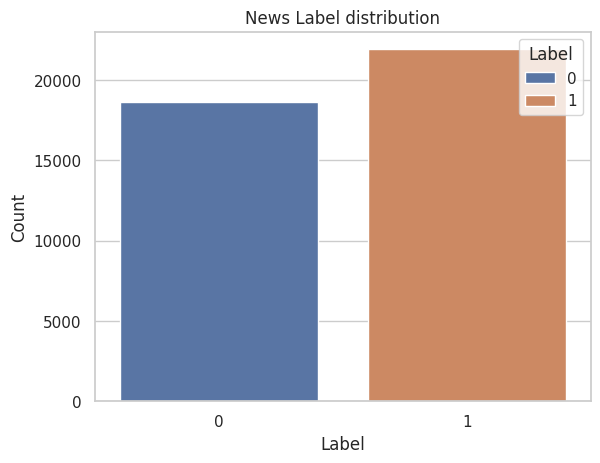

In [11]:
concat_df = pd.concat([train_df,test_df,eval_df])
category_counts = concat_df['label'].value_counts().reset_index()
category_counts.columns = ['Label', 'Count']

sns.set_theme(style="whitegrid")
sns.barplot(x='Label', y='Count', data=category_counts,hue = 'Label',legend=True)

plt.title("News Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")

print(concat_df['label'].value_counts()/len(concat_df))

# Normalization des données, entrainer un tokenizer et visualisation 

### Question 2 :
À l'aide des deux liens ci-dessous, entraîner un tokenizer BPE sur l'ensemble de votre jeu de données.


Build a tokenizer from scratch = https://huggingface.co/docs/tokenizers/quicktour

Building a tokenizer, block by block = https://huggingface.co/learn/nlp-course/chapter6/8

In [12]:

# Function to generate training corpus from dataset
def get_training_corpus(dataset, column_name="content"):
    for i in range(0, len(dataset), 1000):
        yield dataset[column_name].iloc[i : i + 1000].astype(str).tolist()

# Initialize the tokenizer with a BPE model
tokenizer = Tokenizer(BPE())

# Set normalizers (optional: lowercase, NFD, etc.)
tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()])

# Set pre-tokenizer
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace() # pre_tokenizers.ByteLevel(add_prefix_space=True) #

# Define the BPE trainer with a vacab_size = 25_000
trainer = trainers.BpeTrainer(vocab_size=25_000)

# Train the tokenizer
tokenizer.train_from_iterator(get_training_corpus(pd.concat([train_df,eval_df],axis=0)), trainer=trainer)


In [18]:
os.makedirs("../data/tokenizers",exist_ok=True)
#Save the tokenizer
tokenizer.save("../data/tokenizers/tokenizer.json")

In [19]:

#load the tokenizer
tokenizer = Tokenizer.from_file("../data/tokenizers/tokenizer.json")

### Question 3 : 
Expliquer les sorties de "tokenizer.encode(txt)", ajouter une nouvelle colonne aux datasets avec la liste des "ids" pour chaque "content". 

In [20]:
#Sample 1 original content
sample_text = train_df.sample().content.values[0]

# Encode the sample text using the tokenizer
encoded_output = tokenizer.encode(sample_text)

# Print results in a structured way
print("Original Text:")
print(sample_text)

print("\nTokenized Output (Tokens):")
print(encoded_output.tokens)

print("\nTokenized Output (IDs):")
print(encoded_output.ids)

print("\nNumber of Tokens:")
print(len(encoded_output.ids))

print("\nDecoded Text:")
print(tokenizer.decode(encoded_output.ids))

Original Text:
new report uncovers secret trump server that repeatedly communicated with russia world leaders personal chefs sample indian market fare wed oct   pm news bulletin the chefs to various heads of state pose for a photograph as they visit the spice market in the old quarters of new delhi on october   afp 
the worlds most highprofile chefs are in india to explore one of the most gastronomic societies on earth 
members of the exclusive cooking society le club des chefs des chefs have gathered up in new delhi to sample indias spicy and aromatic cuisine 
the culinary delegate comprising personal chefs to the worlds leaders decided to hold a meeting in india after being invited by the countrys president they got the chance to explore the crowded alleys of old delhis pungent spice market and get a taste of the countrys authentic ingredients 
the top chefs get together every year for a general assembly the meeting is supposed to provide a platform for the gourmands to exchange reci

In [24]:
exemple_df = train_df.sample(10)
exemple_df["tokens"] = exemple_df["content"].apply(lambda txt : tokenizer.encode(txt).tokens)
exemple_df["ids"]= exemple_df["content"].apply(lambda txt : tokenizer.encode(txt).ids) 

display_random_sample(exemple_df[["content","ids","tokens"]],1) 

,content,ids,tokens
8837,"WATCH HILARIOUS SNL “Draw Muhammed” Contest Skit… We d like to offer a special word of thanks to Pamela Gellar for shining the light on the truth about Americans who are being bullied into submission by muslim terrorists.https://youtu.be/D2mcRb_WXhYThis skit points out the ridiculousness of the argument by the left that we need to draw the free speech line at criticizing Islam. It s okay to criticize Christianity or Judaism. There s no need to fear criticizing other faiths, but criticize Islam and threats made against your life are apparently justified. Funny we don t remember seeing anything in the First Amendment that exempts American citizens from criticizing Muhammed or the Islam faith","[849, 5623, 10192, 84, 2419, 10011, 357, 85, 3054, 11752, 87, 166, 41, 401, 107, 2949, 38, 1524, 2678, 116, 3652, 107, 17219, 18618, 112, 130, 16496, 99, 2053, 98, 99, 2290, 286, 958, 227, 179, 588, 12715, 480, 17002, 192, 871, 2805, 13, 1792, 1786, 2495, 13, 127, 14, 41, 17, 50, 195, 39, 36, 18595, 1890, 224, 11752, 2245, 186, 99, 4432, 1319, 116, 99, 4848, 192, 99, 948, 135, 166, 622, 107, 2419, 99, 1169, 1103, 933, 101, 6521, 891, 13, 111, 56, 5139, 107, 7274, 8903, 103, 21870, 13, 390, 56, 283, 622, 107, 2381, 6521, ...]","[watch, hilarious, snl, “, draw, muham, med, ”, contest, skit, …, we, d, like, to, offer, a, special, word, of, thanks, to, pamela, gell, ar, for, shining, the, light, on, the, truth, about, americans, who, are, being, bullied, into, submission, by, muslim, terrorists, ., https, ://, youtu, ., be, /, d, 2, m, cr, b, _, wx, hy, this, skit, points, out, the, ridiculous, ness, of, the, argument, by, the, left, that, we, need, to, draw, the, free, speech, line, at, criticizing, islam, ., it, s, okay, to, criticize, christianity, or, judaism, ., there, s, no, need, to, fear, criticizing, ...]"


### question 4 :
Proposer une visualisation sous forme de nuage de mots pour les faux  et les vrais articles. Vous pourrez exclure les mots de liaisons et la ponctuation ("a", "the", "," ...) qui n'apportent pas d'information en utilisant la bibliothèque "nlk" et sa base de "stop_word" en anglais. 

In [25]:

concat_df = pd.concat([train_df,eval_df],axis=0)
concat_df["tokens"] = concat_df["content"].apply(lambda txt : tokenizer.encode(txt).tokens)
concat_df["ids"]= concat_df["content"].apply(lambda txt : tokenizer.encode(txt).ids) 

# Step 1: Extract Vocabulary
vocab = tokenizer.get_vocab()  # Returns a dictionary {word: token_id}
id_to_word = {id: word for word, id in vocab.items()}  # Reverse mapping


# Step 2: Count Word Frequencies
# Flatten the list of token IDs
all_ids  = [id for ids in concat_df["ids"] for id in ids]
all_ids_fake = [id for ids in concat_df[concat_df["label"] == 0]["ids"] for id in ids]
all_ids_true = [id for ids in concat_df[concat_df["label"] == 1]["ids"] for id in ids]

# Count the frequency of each token ID
id_counts = Counter(all_ids)
id_counts_fake = Counter(all_ids_fake)
id_counts_true = Counter(all_ids_true)

# Step 3: Map Token IDs to Words
# Convert token frequencies to word frequencies
word_frequencies = {id_to_word[id]: count for id, count in id_counts.items() if id in id_to_word}
word_frequencies_fake = {id_to_word[id]: count for id, count in id_counts_fake.items() if id in id_to_word}
word_frequencies_true = {id_to_word[id]: count for id, count in id_counts_true.items() if id in id_to_word}


In [26]:
nltk.download('stopwords')

ponctuation_set = {'(', ')', ',', '-', '.', ':', '’', '“'}
# Get the English stop word list and add your ponctuation stop word set
stop_words = set(stopwords.words('english')).union(ponctuation_set)

# Stop word filtration 
filtered_word_frequencies = {word: count for word, count in word_frequencies.items() if word.lower() not in stop_words}
filtered_word_frequencies_fake = {word: count for word, count in word_frequencies_fake.items() if word.lower() not in stop_words}
filtered_word_frequencies_true = {word: count for word, count in word_frequencies_true.items() if word.lower() not in stop_words}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ibotcazou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


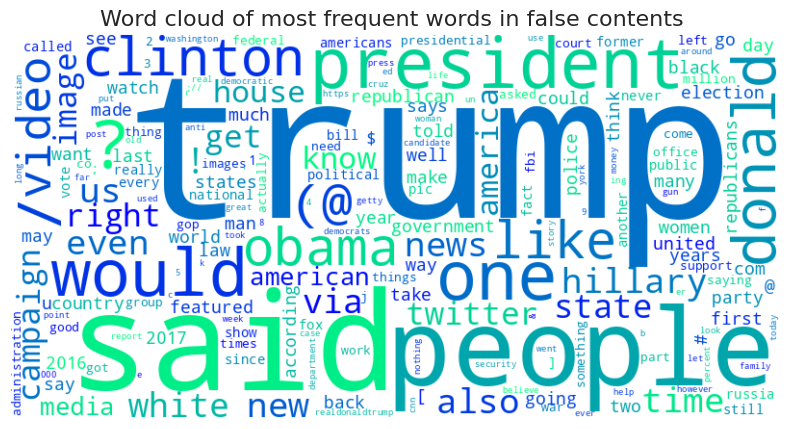

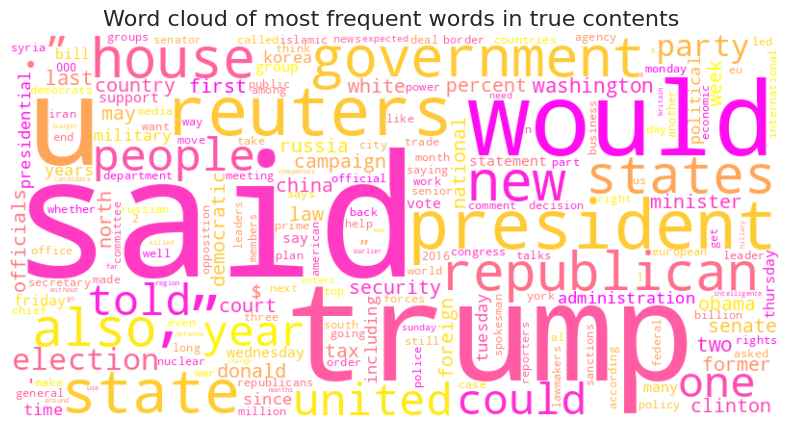

In [27]:
# Step 4: Generate Word Cloud
#link : https://www.kaggle.com/code/niteshhalai/wordcloud-colormap

# Create the WordCloud object
wordcloud_fake = WordCloud(width=800, height=400, background_color="white",colormap="winter").generate_from_frequencies(filtered_word_frequencies_fake)
wordcloud_true = WordCloud(width=800, height=400, background_color="white",colormap="spring").generate_from_frequencies(filtered_word_frequencies_true)

# Display the Word Cloud of fake content 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of most frequent words in false contents ", fontsize=16)
plt.show()

# Display the Word Cloud of true content 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of most frequent words in true contents ", fontsize=16)
plt.show()

#### Question 5 :  
En utilisant la bibliothèque Gesim entrainer un model Word2Vec avec votre jeu de données et votre tokenizer. Explorer ensuite les représentations vectorielles renvoyées par le model sur quelques exemples ("trump", "said", "president", "people", ...)

link1 : https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673

link2 : https://radimrehurek.com/gensim/models/word2vec.html

link3 : https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial


In [28]:

class MyIter:

    def __init__(self,sentences,tokenizer):
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __iter__(self):

        for sentence in self.sentences:
            yield list(tokenizer.encode(sentence).tokens)


concat_df = pd.concat([train_df,eval_df],axis=0)

sentences_iterator = MyIter(sentences = concat_df["content"].to_list(),tokenizer=tokenizer)

In [31]:
w2v_model = Word2Vec(vector_size=100, window=5, min_count=1, sg=1, workers=cores,compute_loss=True) 

w2v_model.build_vocab(sentences_iterator)  # prepare the model vocabulary

for epoch in tqdm.tqdm(range(5)):
    w2v_model.train(sentences_iterator, total_examples=w2v_model.corpus_count, epochs=1)  # train word vectors
   


0


In [36]:
os.makedirs("../models_checkpoints/tp1",exist_ok=True)
#save the model Word2Vec 
w2v_model.save("../models_checkpoints/tp1/fakenews_word2vec.model")

In [38]:
w2v_model = Word2Vec.load("../models_checkpoints/tp1/fakenews_word2vec.model")

#### Exploration des embeddings 

In [39]:
w2v_model.wv.most_similar(positive=["trump"])

[('donald', 0.837069571018219),
 ('elect', 0.673782229423523),
 ('obama', 0.6471015214920044),
 ('birtherism', 0.6470520496368408),
 ('yuge', 0.6462123394012451),
 ('conway', 0.6461073160171509),
 ('he', 0.6363210082054138),
 ('mccarthyism', 0.623471736907959),
 ('kellyanne', 0.6196519732475281),
 ('pence', 0.6142182350158691)]

In [40]:
w2v_model.wv.most_similar(positive=["president"])

[('barack', 0.6682946085929871),
 ('elect', 0.6571961045265198),
 ('presidency', 0.6469955444335938),
 ('presidentelect', 0.6121118664741516),
 ('presidents', 0.5952953696250916),
 ('sarkozy', 0.5921552777290344),
 ('45th', 0.5821550488471985),
 ('donald', 0.5708026885986328),
 ('inaugurated', 0.5671338438987732),
 ('vice', 0.5625112056732178)]

In [41]:
w2v_model.wv.most_similar(positive=["said"])

[('added', 0.8364043831825256),
 ('told', 0.7797532081604004),
 ('adding', 0.7015065550804138),
 ('stressed', 0.6850384473800659),
 ('noted', 0.6735206842422485),
 ('suggested', 0.6677866578102112),
 ('warned', 0.6601254343986511),
 ('acknowledged', 0.6491959691047668),
 ('reiterated', 0.6441456079483032),
 ('saying', 0.6418230533599854)]

# Entrainer un modèle de classification avec des poids aléatoires 

### Question 6 : 

* Construire des datasets train, eval et test avec la classe Dataset. 

link1 : https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

link2 : http://www.idris.fr/jean-zay/gpu/jean-zay-gpu-torch-data-preprocessing.html

* Ajout d'une colonne "input_ids" avec la méthode map

link : https://medium.com/@sujathamudadla1213/what-are-some-benefits-of-using-the-dataset-map-7dab03afb6d3

* Ajouter un index de padding pour les positions a ignorer par le modèle où encore pour compléter dans chaque batch pour obtenir une matrice

* Construire des dataloaders associés qui rajoutent le padding pour chaque batch.


In [42]:
#transforme a pandas df to a torch dataset object 
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(test_df)

In [43]:

# Define a function for tokenization
def tokenize_function(example):
    tokens = tokenizer.encode(example["content"]).ids
    return {"input_ids": tokens}

train_dataset = train_dataset.map(tokenize_function)
eval_dataset = eval_dataset.map(tokenize_function)
test_dataset = test_dataset.map(tokenize_function)


Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [44]:
# Creation d'un index de padding pour les positions a ignorer par le modèle où encore pour compléter dans chaque batch pour obtenir une matrice
pad_idx = tokenizer.get_vocab_size()

print("L'index de padding est :", pad_idx)

L'index de padding est : 25000


In [45]:
# Define the custom collate function
def collate_fn(batch):
    """
    Custom collate function for padding.
    """
    # for item in batch:
    #     print(item["input_ids"])
    
    #convert "input_ids" to torch.Tensor
    tokenized_contents = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch] #self.long() is equivalent to self.to(torch.int64)

    # Pad the tokenized content
    padded_contents = pad_sequence(tokenized_contents, batch_first=True, padding_value=pad_idx)

    #  Extract  and convert labels to a tensor 
    labels = [item["label"] for item in batch] 
    labels = torch.tensor(labels, dtype=torch.long)

    return {
        "input_ids": padded_contents,
        "labels": labels,
    }


In [46]:

# Create a DataLoader
batch_size = 64

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data for training
    collate_fn=collate_fn  # Use custom collate function
)


eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data for training
    collate_fn=collate_fn  # Use custom collate function
)


test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data for training
    collate_fn=collate_fn  # Use custom collate function
)


In [48]:
# Example usage
for batch in train_dataloader:
    #print(batch["input_ids"])
    print(batch["input_ids"].shape)  # Shape of the input_ids tensor
    #print(batch["labels"])
    print(batch["labels"].shape)  # Shape of the labels tensor
    break

torch.Size([64, 1990])
torch.Size([64])


### Question 7 :

Developper une architecture de modèle héritant de la classe "nn.Module" qui converti les "input_ids" en embeddings, les moyennes pour donner une représentation vectorielle à chaque article. Le modèle doit renvoyer une prédiction entre deux classes :

link1 : https://medium.com/@spandey8312/text-classification-using-custom-data-and-pytorch-d88ba1087045

Remarque : vous pourrez utiliser le model Word2Vec précédemment entrainé pour initialiser la table d'embeddings du classifier  


##### Architecture 1

In [49]:
class TextClassifierMean(nn.Module):

    def __init__(self, vocab_size, embedding_dim, embedding_model, num_classes, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.drop=nn.Dropout(dropout)
        self.fc = nn.Linear(embedding_dim, num_classes)

        self.nb_word_out_vocab = 0
        # Access the embedding weights from the model
        embedding_weights = self.embedding.weight.data
        # Initialize a list for new embedding weights
        new_embedding_weights = np.zeros(embedding_weights.shape)

        # Iterate over the vocabulary
        for token, ids in tokenizer.get_vocab().items():
            # Get the word vector from the FastText model

            try:
                word_vector = embedding_model.wv[token]
                new_embedding_weights[ids] = word_vector
            except KeyError as e:
                self.nb_word_out_vocab +=1
                continue
        # Convert the list of word vectors to a tensor
        new_embedding_weights = torch.tensor(new_embedding_weights, dtype=embedding_weights.dtype)

        # Update the embedding weights in the model with the new weights
        with torch.no_grad():  # Disable gradient tracking
            self.embedding.weight.data = new_embedding_weights
        print("Nombre de mots or vocabulaire pour le model d'embedding",self.nb_word_out_vocab)

    
    def forward(self, x):
        embedded = self.embedding(x)
        #print(embedded.shape)
        embedded = self.drop(embedded)
           
        # Sum along axis 1
        mean= torch.mean(embedded, axis=1)

        logits = self.fc(mean)

        return logits

##### Architecture 2

In [50]:
class TextClassifierNormL2(nn.Module):

    def __init__(self, vocab_size, embedding_dim, embedding_model, num_classes, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.drop=nn.Dropout(dropout)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.eps = 1e-6
        self.device = "cpu"

        self.nb_word_out_vocab = 0

        # Access the embedding weights from the model
        embedding_weights = self.embedding.weight.data

        # Initialize a list for new embedding weights
        new_embedding_weights = np.zeros(embedding_weights.shape)

        # Iterate over the vocabulary
        for token, ids in tokenizer.get_vocab().items():
            # Get the word vector from the FastText model

            try:
                word_vector = embedding_model.wv[token]
                new_embedding_weights[ids] = word_vector
            except KeyError as e:
                self.nb_word_out_vocab +=1
                continue


        # Convert the list of word vectors to a tensor
        new_embedding_weights = torch.tensor(new_embedding_weights, dtype=embedding_weights.dtype)

        # Update the embedding weights in the model with the new weights
        with torch.no_grad():  # Disable gradient tracking
            self.embedding.weight.data = new_embedding_weights

        print("Nombre de mots or vocabulaire pour le model d'embedding",self.nb_word_out_vocab)
    
    def to(self,device):
        super().to(device)
        self.device = device 
    
    def forward(self, x):
        embedded = self.embedding(x)
        #print(embedded.shape)

        embedded = self.drop(embedded)

        # Sum along axis 1
        summed = torch.sum(embedded, axis=1)

        # Compute the norm along dim=-1
        norm = torch.norm(summed, dim=-1, keepdim=True)


        #print(norm.shape)

        # Create a mask for values close to zero
        mask = torch.isclose(norm, torch.zeros((norm.shape)).to(self.device))
        #print(mask)

        # Add eps only where norm is close to zero
        adjusted_norm = norm + self.eps * mask.float()

        # Perform the division
        pooling = summed / adjusted_norm

        logits = self.fc(pooling)

        return logits

## initialisation des modèles :

In [96]:
# Training parameters
vocab_size = tokenizer.get_vocab_size()
embedding_dim = 100
num_classes = 2


In [97]:
model_classifier_1 = TextClassifierMean(vocab_size, embedding_dim,w2v_model, num_classes)

# exemple aléatoire de "inputs_ids"
inputs_ids_test = torch.randint(low=0,high=200,size=(3,14)) #batch_size, Idx_token 
print(inputs_ids_test)

with torch.no_grad():
    model_classifier_1.eval() #permet de ne pas prendre en compte le dropout
    output_model_test = model_classifier_1(inputs_ids_test)
    
    print(output_model_test)

Nombre de mots or vocabulaire pour le model d'embedding 509
tensor([[183, 199, 198,  32,  18,  92,  14, 177, 194,   5, 135, 197,  88, 182],
        [ 93,  32,  68,  55,  94, 162,  15,   5,  26, 172,  80, 162,   0,  78],
        [135,  93,  25, 127,  65,  66, 134,  60,  71,  21,  30, 108, 138,   9]])
tensor([[-0.0853,  0.0086],
        [-0.0869,  0.0064],
        [-0.0812, -0.0123]])


In [55]:

model_classifier_2 = TextClassifierNormL2(vocab_size, embedding_dim,w2v_model, num_classes)

# exemple aléatoire de "inputs_ids"
inputs_ids_test = torch.randint(low=0,high=200,size=(3,14)) 
print(inputs_ids_test)

with torch.no_grad():
    model_classifier_2.eval() #permet de ne pas prendre en compte le dropout
    output_model_test = model_classifier_2(inputs_ids_test)
    
    print(output_model_test)

Nombre de mots or vocabulaire pour le model d'embedding 509
tensor([[164, 167, 108, 180, 171, 134, 109,  39, 192, 114, 124,  65, 133, 190],
        [ 92, 142, 154, 174,  79,  75, 159, 150,  47,  86,  83, 153, 145,  80],
        [126,  28, 139,  14,  92,  61,  25,  28,  52, 163,  24, 199, 101,  33]])
tensor([[0.0851, 0.0588],
        [0.1402, 0.0658],
        [0.0673, 0.0916]])


### Vérifier que la table d'embeddings du model est bien synchronisée avec les embeddings du model Word2Vec

In [98]:
vocab_items = list(tokenizer.get_vocab().items())
random_token, random_index = vocab_items[np.random.choice(len(vocab_items))]

print("Randomly selected token:", random_token)
print("Index of the token:", random_index)

try:
    word_vector = torch.tensor(w2v_model.wv[random_token])
    print( word_vector == model_classifier_1.embedding.weight.data[random_index])

except KeyError as e:
    print(e)




Randomly selected token: ney
Index of the token: 988
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


### Question 8 : 

Reprendre la fonction "train_test" dans "module_train_tp1.py" et entrainer les poids de votre modèle sur 15 epochs.

In [99]:
import module_train_tp1 as trainer
importlib.reload(trainer)

<module 'module_train_tp1' from '/home/ibotcazou/Bureau/NLP_presentation/src/module_train_tp1.py'>

In [100]:
num_epochs = 15
learning_rate = 1e-3

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_classifier_1.parameters(), lr=learning_rate)

In [101]:
os.makedirs("../models_checkpoints/tp1",exist_ok=True)
os.makedirs("./logs/tp1",exist_ok=True)

time = datetime.now().strftime("%Y%m%d_%H%M")
model_class = "TextClassifierMean_"

model_name = model_class + time + ".checkpoint.pth"
checkpoint_path = os.path.join("../models_checkpoints/tp1",model_name)

log_dir = "logs/tp1/" + model_class + time


In [102]:

list_train_loss, list_eval_loss ,list_train_accuracy, list_eval_accuracy ,list_train_f1, list_eval_f1 = trainer.train_test(
    train_iter=train_dataloader,
    eval_iter=eval_dataloader,
    model=model_classifier_1, 
    loss_function=criterion,
    optimizer=optimizer, 
    epochs=num_epochs, 
    log_dir = log_dir,
    checkpoint_path = checkpoint_path,
    device = device,
    early_stopping_patience=15, 
    reduce_lr_patience=5,
    reduce_lr_factor=0.1
    )

  7%|▋         | 1/15 [01:15<17:38, 75.61s/it]

Find a better model at the epoch 1 - Train Loss: 0.5498, eval Loss: 0.3655


 13%|█▎        | 2/15 [02:27<15:54, 73.40s/it]

Find a better model at the epoch 2 - Train Loss: 0.2974, eval Loss: 0.2291


 20%|██        | 3/15 [03:38<14:29, 72.44s/it]

Find a better model at the epoch 3 - Train Loss: 0.2127, eval Loss: 0.1761


 27%|██▋       | 4/15 [04:51<13:15, 72.36s/it]

Find a better model at the epoch 4 - Train Loss: 0.1688, eval Loss: 0.1502


 33%|███▎      | 5/15 [06:01<11:57, 71.79s/it]

Find a better model at the epoch 5 - Train Loss: 0.1381, eval Loss: 0.1305


 40%|████      | 6/15 [07:17<10:58, 73.21s/it]

Find a better model at the epoch 6 - Train Loss: 0.1183, eval Loss: 0.1167


 47%|████▋     | 7/15 [08:35<09:58, 74.79s/it]

Find a better model at the epoch 7 - Train Loss: 0.1022, eval Loss: 0.1091


 53%|█████▎    | 8/15 [09:57<08:59, 77.08s/it]

Find a better model at the epoch 8 - Train Loss: 0.0873, eval Loss: 0.1016


 67%|██████▋   | 10/15 [12:43<06:38, 79.67s/it]

Find a better model at the epoch 10 - Train Loss: 0.0655, eval Loss: 0.0882


 73%|███████▎  | 11/15 [14:01<05:16, 79.01s/it]

Find a better model at the epoch 11 - Train Loss: 0.0586, eval Loss: 0.0863


 80%|████████  | 12/15 [15:19<03:56, 78.72s/it]

Find a better model at the epoch 12 - Train Loss: 0.0517, eval Loss: 0.0838


 87%|████████▋ | 13/15 [16:34<02:35, 77.77s/it]

Find a better model at the epoch 13 - Train Loss: 0.0460, eval Loss: 0.0835


100%|██████████| 15/15 [19:07<00:00, 76.53s/it]

Find a better model at the epoch 15 - Train Loss: 0.0377, eval Loss: 0.0797


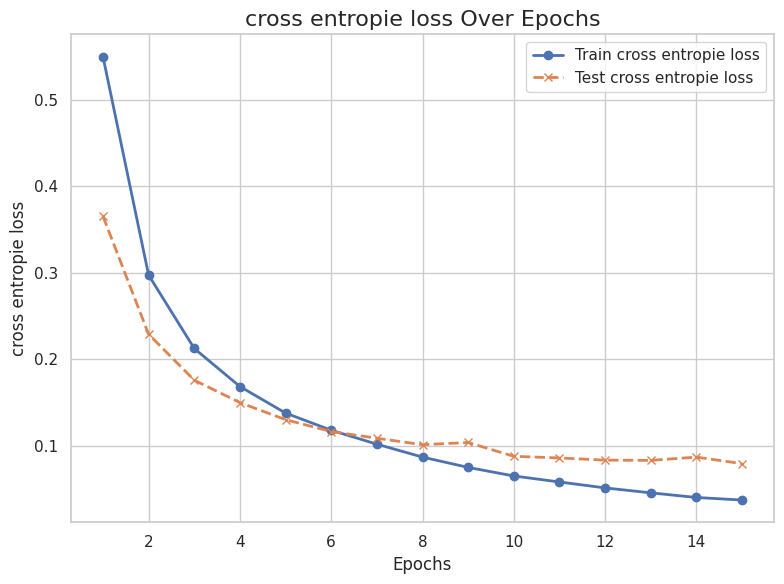

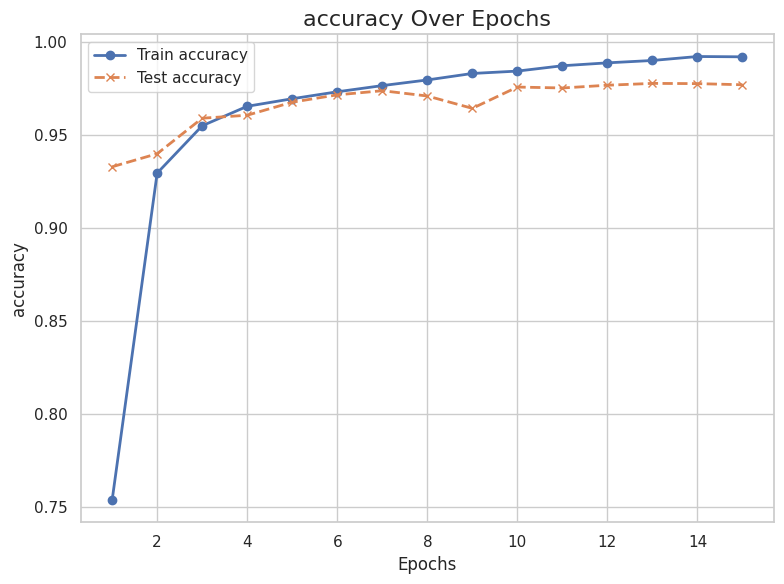

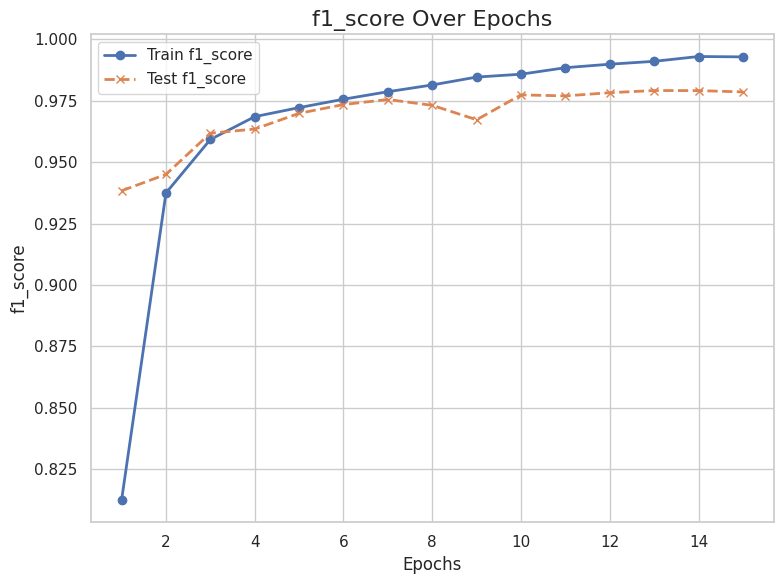

In [103]:
trainer.plot_metrics(list_train_loss, list_eval_loss, "cross entropie loss")
trainer.plot_metrics(list_train_accuracy, list_eval_accuracy , "accuracy")
trainer.plot_metrics(list_train_f1, list_eval_f1, "f1_score")


### Question 9 :
Evaluer le model sur les données test et exhiber des exemples d'articles prédit avec un mauvais label. 


In [107]:
#Chargement des modèles entrainés

#model_name = "TextClassifierMean_20250130_1631.checkpoint.pth"
checkpoint_path = os.path.join("../models_checkpoints/tp1",model_name)

w2v_model = Word2Vec.load("../models_checkpoints/tp1/fakenews_word2vec.model")


model= TextClassifierMean(vocab_size, embedding_dim,w2v_model, num_classes)
model.load_state_dict(torch.load(checkpoint_path,weights_only=False))
model.to(device)

Nombre de mots or vocabulaire pour le model d'embedding 509


TextClassifierMean(
  (embedding): Embedding(25001, 100)
  (drop): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

#### Evaluation du model sur le jeu de données test 

In [108]:
# Evaluation du modèle de classification sur les données test
model.eval()
total_test_loss = 0.0
total_test_samples = 0

correct_predictions_test = 0

predict_labels_test_list = []
targets_test_list = []

with torch.no_grad():
    for batch in test_dataloader:

        input_ids = batch['input_ids'].to(device)
        targets = batch["labels"].to(device)

        outputs = model(input_ids).to(device)
        test_loss = criterion(outputs, targets)

        total_test_loss += test_loss.item() * len(input_ids)
        total_test_samples += len(input_ids)

        predicted_labels = torch.argmax(outputs, dim=1)

        correct_predictions_test += (predicted_labels == targets).sum().item() #compte le nb de bonne prédiction

        predict_labels_test_list.extend(predicted_labels.tolist())
        targets_test_list.extend(targets.tolist())
       

loss_test = total_test_loss/total_test_samples


accuracy_test = correct_predictions_test / total_test_samples
precision_test = precision_score(targets_test_list, predict_labels_test_list)
recall_test = recall_score(targets_test_list, predict_labels_test_list)
f1_score_test =  f1_score(targets_test_list, predict_labels_test_list)


In [109]:
# Print the metrics in a clear format
print(f"Test Metrics:")
print(f"Loss: {loss_test:.4f}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_score_test:.4f}")

Test Metrics:
Loss: 0.0759
Accuracy: 0.9815
Precision: 0.9797
Recall: 0.9860
F1 Score: 0.9829


#### Visualisation des mauvaises predictions 

In [110]:

def prediction_for_row(row,tokenizer,model):

    input_ids = tokenizer.encode(row['content']).ids

    # Convert the input to tensors
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)  # Add batch dimension

    # Set the model to eval mode
    model.eval()

    # Predict
    with torch.no_grad():
        outputs = model(input_ids)
        predicted_label = torch.argmax(outputs, dim=-1).item()
    
    return predicted_label

# Partial function to pass fixed arguments
predict_fn = partial(prediction_for_row,tokenizer=tokenizer, model=model)  


# Map the prediction function to each row
test_dataset = test_dataset.map(lambda row: {"predict_label": predict_fn(row)}, batched=False)

# Optionally convert back to a pandas DataFrame if needed
test_dataframe = test_dataset.to_pandas()


Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [132]:
error_prediction_df = test_dataframe[test_dataframe["label"] != test_dataframe["predict_label"]]
good_prediction_df = test_dataframe[test_dataframe["label"] == test_dataframe["predict_label"]]

display_random_sample(error_prediction_df[['title', 'text', 'label','predict_label']],1) 
display_random_sample(good_prediction_df[['title', 'text', 'label','predict_label']],1) 


,title,text,label,predict_label
1913,destruction of us abrams tank mosul offensive good for general dynamics,oped by laraine c abbey president obamas statement giving up some freedom in exchange for security was a lance through my heart give up,0,1


,title,text,label,predict_label
4445,WOW! Why George W. Bush Never Left DC Until After Christmas Day,"Meanwhile, the Obama s jet off to Hawaii every year well before Christmas. When you read the reason why the Bush s wait in DC until after Christmas day, you ll see why its really all about putting others before yourself Like many Americans, U.S. presidents often take time off around the holidays.However, according to journalist Joseph Curl, who previously covered the White House, former President George W. Bush went on Christmas vacation in a way that stands in direct contrast to President Barack Obama. [H]ere s the thing: In December, we never left Washington, D.C., until the day after Christmas. Never. Mr. Bush and his wife, Laura, would always depart the White House a few days before the holiday and hunker down at Camp David, the presidential retreat in Maryland, Curl wrote in a 2013 column that was republished Thursday.After a few years, curiosity finally got to the former Washington Times reporter and he asked a low-level administration official why. I still remember what she said, Curl wrote. So all of us can be with our families on Christmas. Who was us ? Hundreds and hundreds of people, that s who. Sure, the reporters who covered the president, but also dozens and dozens on his staff, 100 Secret Service agents, maybe more, and all of those city cops required whenever the president s on the move in D.C., Curl added in his column.However, things seemingly changed when Obama took office. [T]his president would never delay his trip to his island getaway. He s off every year well before Christmas. Hundreds and hundreds head off with him, leaving family behind, Curl wrote. No Christmas at home, he added. Instead, the Hawaiian Village Waikiki Beach Resort. Nice, but not exactly home. Via: The Blaze",0,0


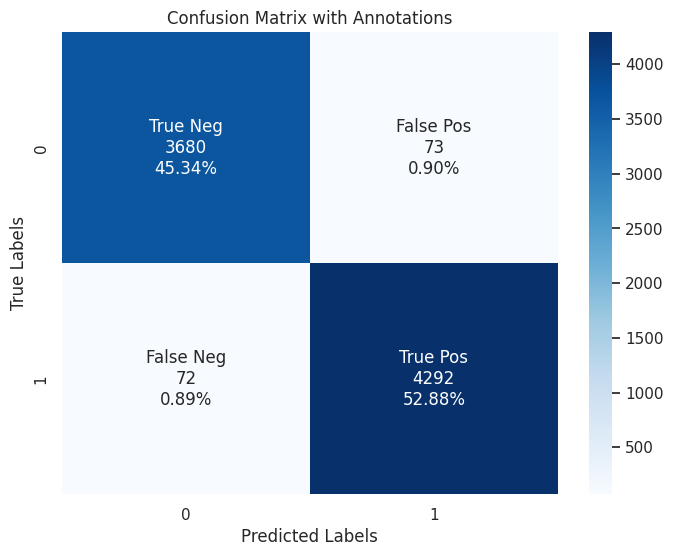

In [112]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

##link : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

# Generate the confusion matrix
y_true = test_dataframe.label.values
y_pred = test_dataframe.predict_label.values
confu_mat = confusion_matrix(y_true, y_pred)

# Define group names
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

# Compute counts for each group
group_counts = ["{0:0.0f}".format(value) for value in confu_mat.flatten()]

# Compute percentages for each group
group_percentages = ["{0:.2%}".format(value) for value in confu_mat.flatten() / np.sum(confu_mat)]

# Combine names, counts, and percentages into a single label
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

# Reshape labels to match the confusion matrix shape
labels = np.asarray(labels).reshape(confu_mat.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confu_mat, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix with Annotations')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Projection des sentences embedding avec label 

In [167]:
def get_sentence_emb(batch):
    # Set the model to eval mode
    model.eval()

    # Predict
    with torch.no_grad():
        outputs =  torch.mean(model.embedding(batch["input_ids"]), axis=1)
    
    return {
        "sentence_embedding": outputs.detach(),
        "labels":batch["labels"].detach()
    }

sentences_embeddings = torch.tensor([])
labels =  torch.tensor([])

for batch in test_dataloader:
    out = get_sentence_emb(batch)
    sentences_embeddings = torch.cat((sentences_embeddings,out["sentence_embedding"]))
    labels = torch.cat((labels,out["labels"]))

In [175]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(sentences_embeddings.numpy())

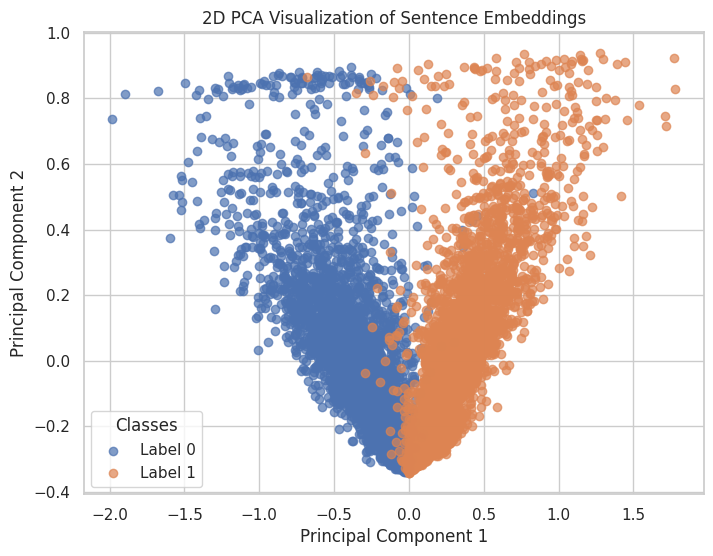

In [188]:

# Convert labels to integers if needed (in case they are strings)
unique_labels = np.unique(labels).astype(int)

# Create scatter plot with a legend
plt.figure(figsize=(8, 6))
for label in unique_labels:
    mask = labels == label  # Select points belonging to this label
    plt.scatter(components[mask, 0], components[mask, 1], label=f"Label {label}", alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization of Sentence Embeddings')
plt.legend(title="Classes", loc='best')
plt.show()

### Proposer votre des exemples d'articles aliant fake-news et vrais articles et observez comment votre modèle généralise son apprentissage. 

In [138]:
#link = https://library-nd.libguides.com/fakenews/examples

content_fake = """
Hey Facebook, As some of you may know, I'm Bill Gates. If you click that share link, I will give you $5,000. 
I always deliver, I mean, I brought you Windows XP, right?
"""

row = {
    "content" : content_fake}

label = predict_fn(row)

print(label)

0


In [139]:
content_fake = """
On 15 May 2014, the National Report published an article reporting that Barack Obama had (in defiance of constitutional provisions) shockingly proclaimed he would be seeking a third term as President of the United States:

President Barack Obama shocked the country this morning with news that he is running for a third term

"I can't abandon the American people now when they need me more than ever," Obama told reporters at a press conference this morning. "We've come this far as a nation, now is not the time to do something different. This is the change you wanted and this is the change you’re getting." 

"""

row = {
    "content" : content_fake}

label = predict_fn(row)

print(label)

0


In [141]:
#link = https://www.bbc.com/news/articles/cq5eewvy3nlo

content_true= """
Donald Trump was rushed to safety on Sunday after what the FBI termed an apparent assassination attempt at his golf course in West Palm Beach, Florida.

Ryan Wesley Routh, 58, was arrested and charged with firearms offences.

The incident comes almost exactly two months after a shooting at a Trump rally in Butler, Pennsylvania, which left the Republican nominee with minor injuries and killed a man in the crowd.

Here is what we know so far about Sunday.
How was the suspect spotted?

The incident unfolded at the Trump International Golf Club in West Palm Beach, about 15 minutes from Trump's Florida residence, Mar-a-Lago.

A gunman was first seen by Secret Service agents, who were sweeping the course. Agents usually go one hole ahead to perform security checks, according to police.

The muzzle of a rifle - an SKS semi-automatic - was spotted sticking through the shrubbery that lines the course.

At the time, Trump was about 300-500 yards (275-460m) away from the spot.

An agent "immediately engaged" with the person holding the rifle, who fled, Sheriff Rik Bradshaw said. The suspect did not fire his weapon during the incident.

On 16 September, acting Secret Service director Ron Rowe said Trump was "across the course and out of sight of the sixth green" when the Secret Service agent opened fire.

At no point is the suspect believed to have had a clear line of sight to the former president.

Records show that Routh's phone had been in the area for about 12 hours, from around 02:00 to 13:31 local time, according to court documents and police officials. 

"""

row = {
    "content" : content_true}

label = predict_fn(row)

print(label)

0


In [140]:
#link = https://www.bbc.com/news/articles/cr56gr6p49eo

content_true="""Russia claims that its forces have captured the front-line town of Kurakhove in eastern Ukraine's Donetsk region.

The town has borne the brunt of Russian advances in recent months and is a stepping-stone to the key logistical hub of Pokrovsk.

Ukraine has not acknowledged the fall of Kurakhove, which is 35km (21 miles) south of Pokrovsk.

Fierce fighting has also been under way in Russia's Kursk region in recent days after Ukraine launched a counter-attack on Sunday.

An image taken from social media and supplied by the Reuters news agency appears to show a soldier holding up a Russian flag in Kurakhove. The image has not been verified by the BBC.

Viktor Trehubov, spokesperson for Ukraine's Khortytsia group of forces, told Reuters news agency that, as of Monday morning, Ukrainian forces were still engaging Russian troops inside Kurakhove.

Kurakhove is linked to Pokrovsk by roads that are part of the infrastructure to move troops and supplies along the front line.

The taking of Kurakhove would allow the Russians to go north to attack Pokrovsk from a new direction, analyst Roman Pohorily said.

Russia's defence ministry also claimed on Monday that the village of Dachenske, which about 8km south of Pokrovsk, had been captured by its forces.

Kyiv's forces are reportedly suffering from manpower shortages and have been losing ground in the east of Ukraine in recent months, as Russian troops advance.

"""

row = {
    "content" : content_true}

label = predict_fn(row)

print(label)

1
